In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import re
import os
from scipy.optimize import curve_fit

main_folder = Path('.')

# Make an empty list to store dataframes
all_dataframes = []

# Loop through all subfolders within the main folder
for subfolder in main_folder.iterdir():
    if subfolder.is_dir():
        # Loop through all CSV files within the subfolder
        for csv_file in subfolder.glob('*.csv'):  # Find all CSV files in the folder
            try:
                # Load each CSV file into a pandas dataframe
                df = pd.read_csv(csv_file, encoding='ISO-8859-1', skiprows=7)
            except Exception as e:
                print(f"Error reading {csv_file}: {e}") # Skip to the next file if there's an error
                continue 

            # Add the folder/file name as columns to the dataframe for reference
            df['source_folder'] = subfolder.name
            # Add pretty name, replacing underscore with space
            df['source_folder_label'] = subfolder.name.replace('_', ' ')
            # Shorten csv file name to remove .csv suffix and RunX_ prefix
            df['source_file'] = csv_file.name[5:-4]
            # Add pretty name, replacing underscore with space
            df['source_file_label'] = csv_file.name[5:-4].replace('_', ' ')
            # Add linear Magnitude
            df['Linear Magnitude'] = 10**(df['Magnitude(dB)'] / 20.0)
            
            # Append the dataframe to the list
            all_dataframes.append(df)

# Concatenate all the dataframes into one dataframe
combined_df = pd.concat(all_dataframes, ignore_index=True)

print(combined_df)

      Sample  Frequency(Hz)  Magnitude(dB)    Phase(°) source_folder  \
0          0        1000.00        19.3815    0.375070      Response   
1          1        1010.19        19.3097    0.076424      Response   
2          2        1020.48        19.3331    0.067271      Response   
3          3        1030.88        19.3288    0.056025      Response   
4          4        1041.38        19.3365    0.058827      Response   
...      ...            ...            ...         ...           ...   
6395      95    16605300.00       -16.2483 -292.000000      Response   
6396      96    18393700.00       -17.2191 -305.000000      Response   
6397      97    20374800.00       -17.7452 -325.000000      Response   
6398      98    22569200.00       -17.8649    8.406300      Response   
6399      99    25000000.00       -18.9729  -36.268700      Response   

     source_folder_label      source_file source_file_label  Linear Magnitude  
0               Response  ADA4898-1_100mV   ADA4898-1 1

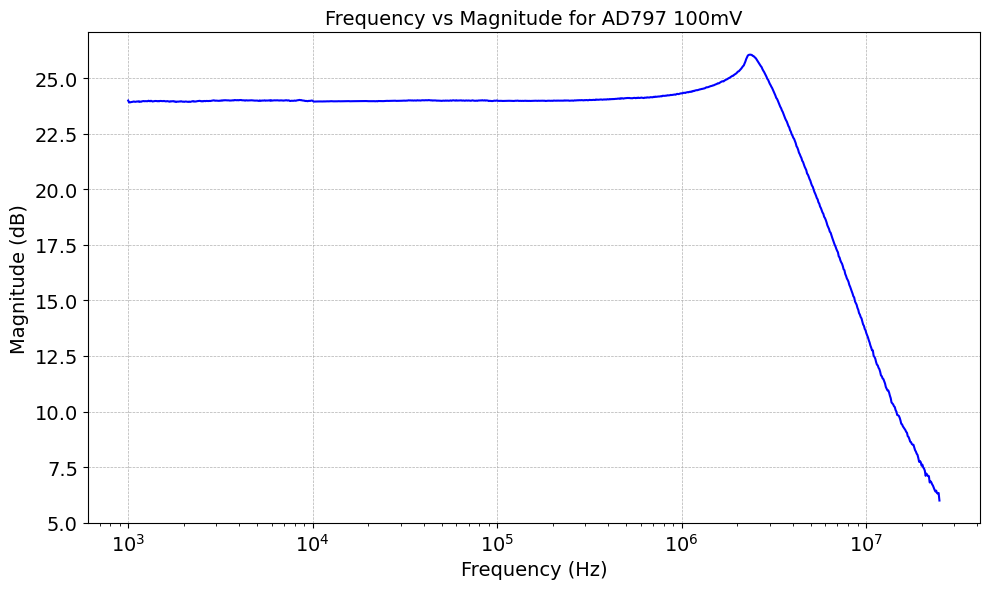

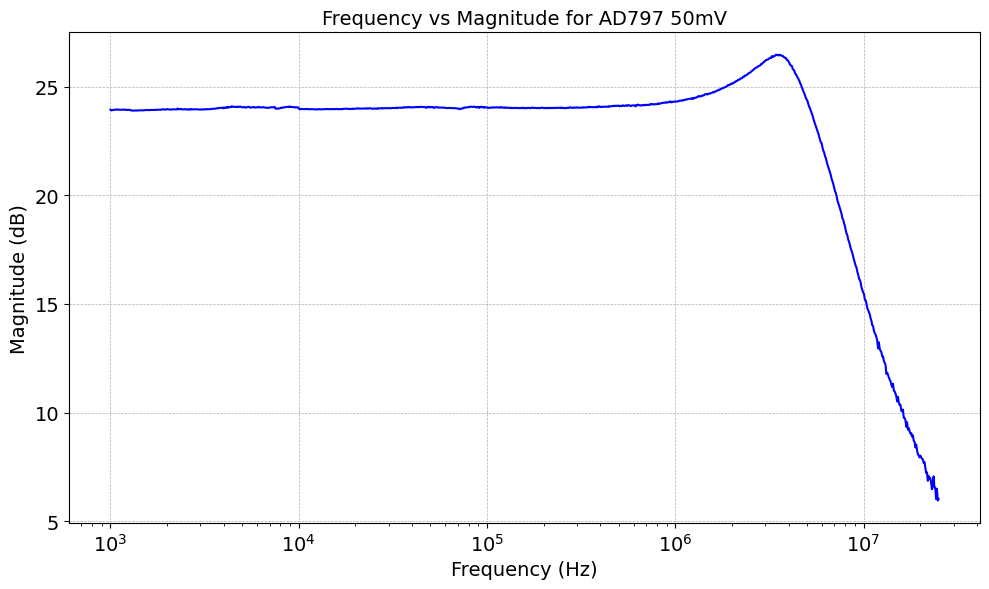

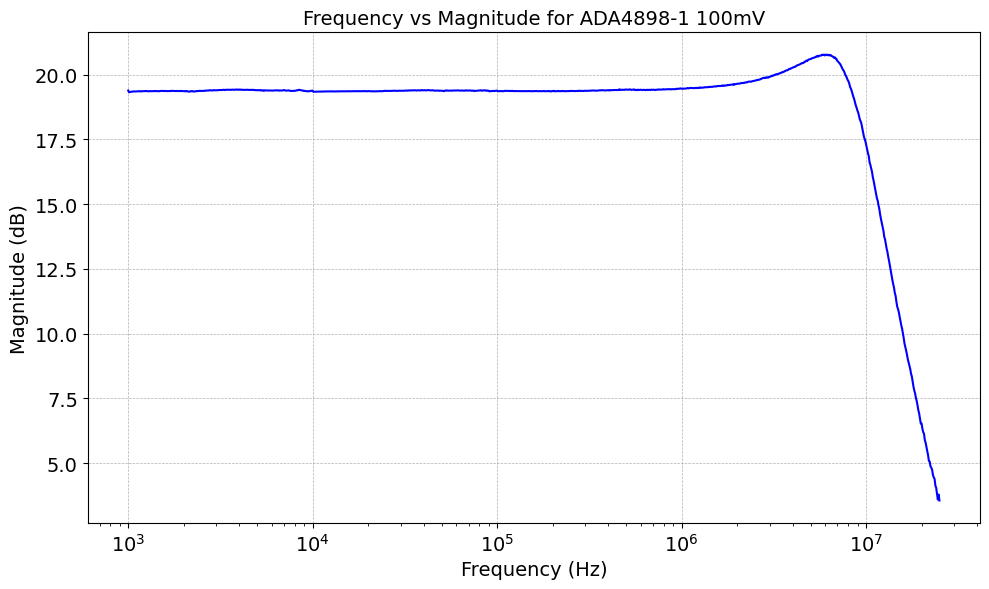

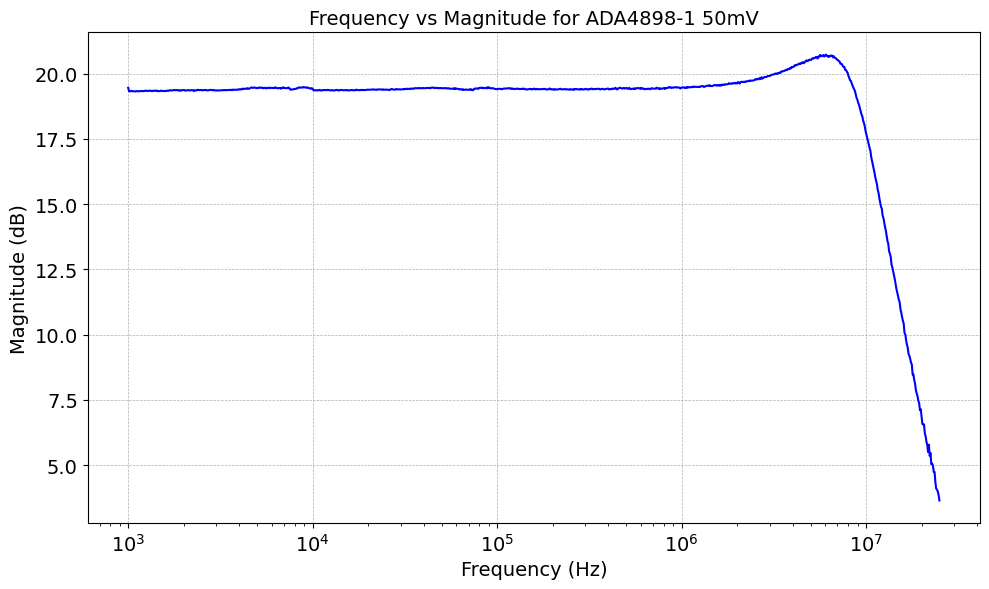

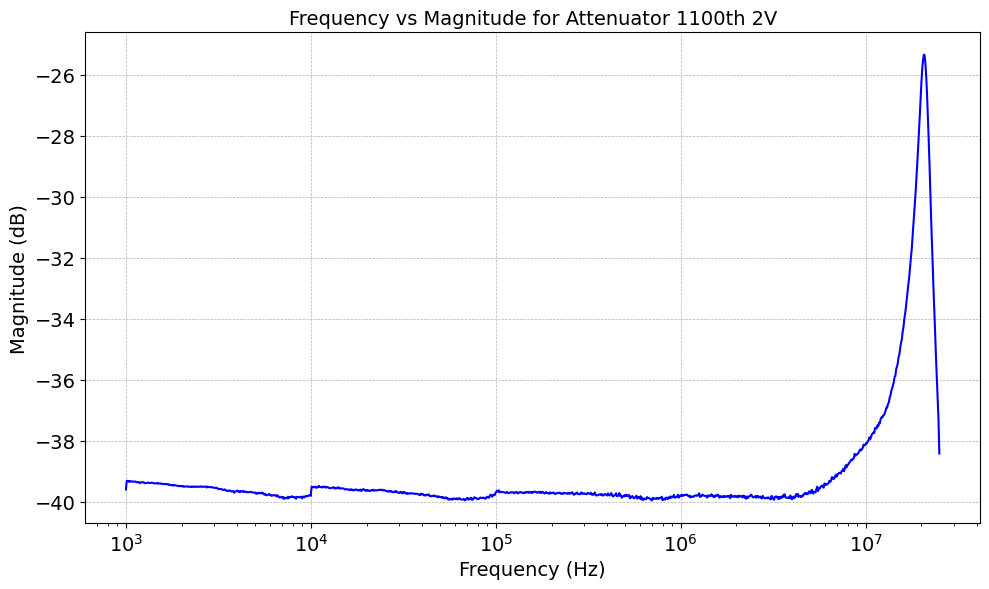

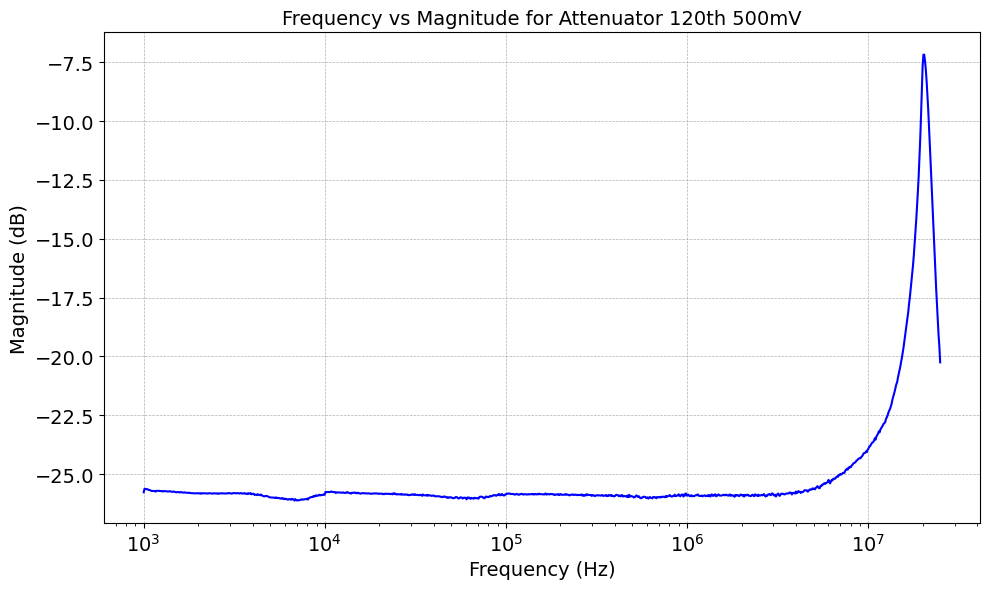

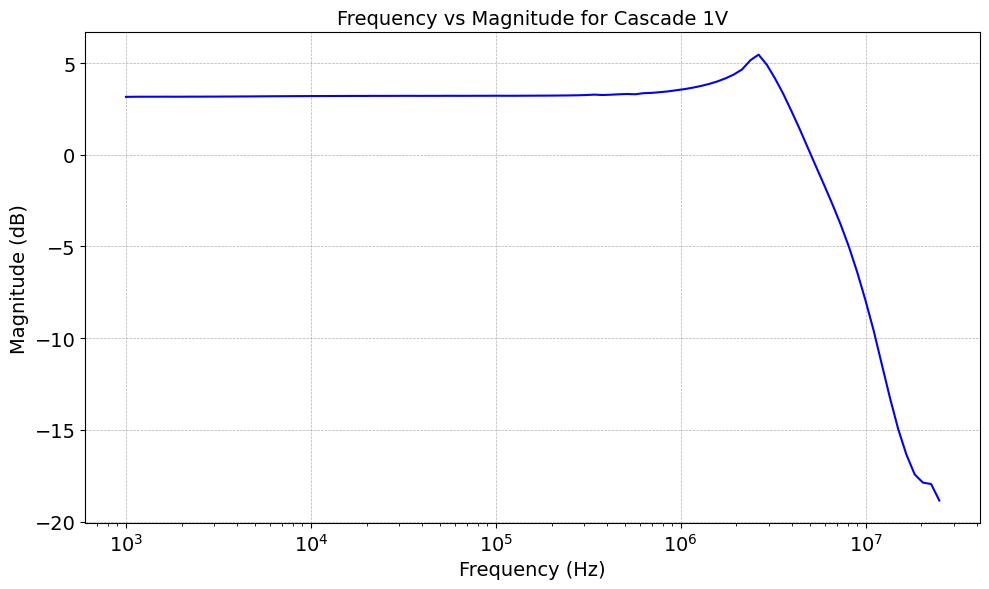

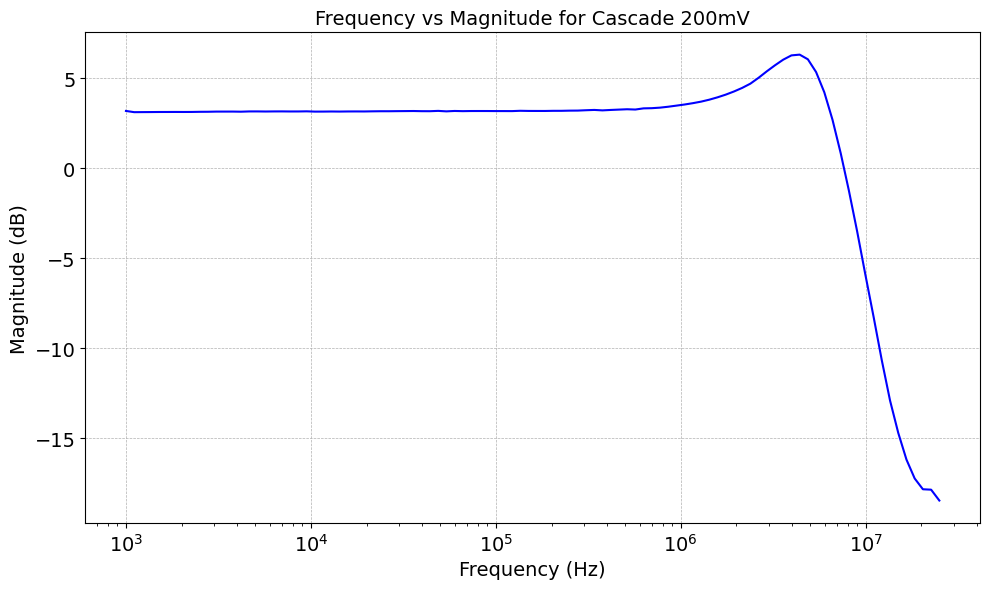

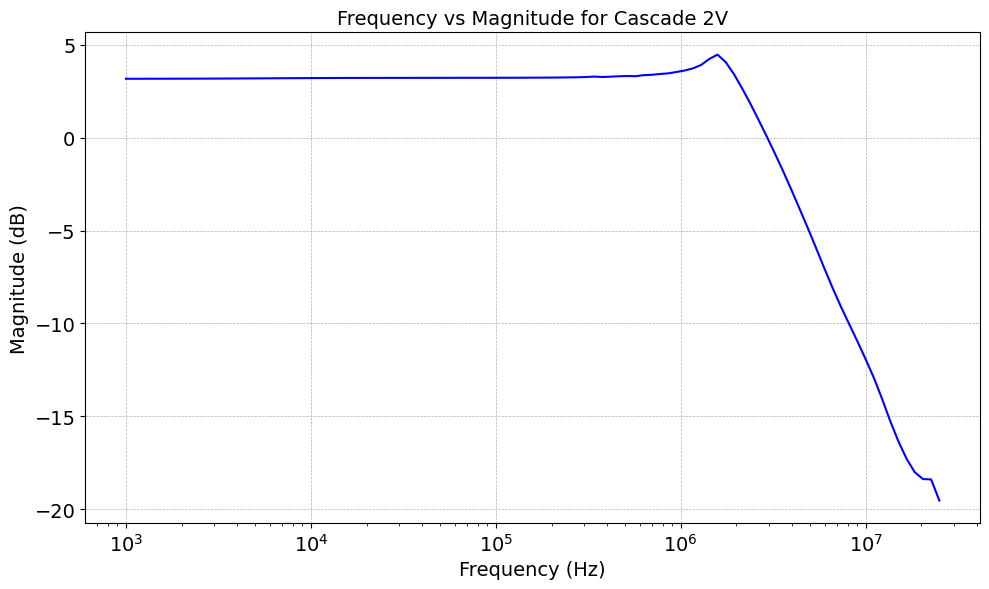

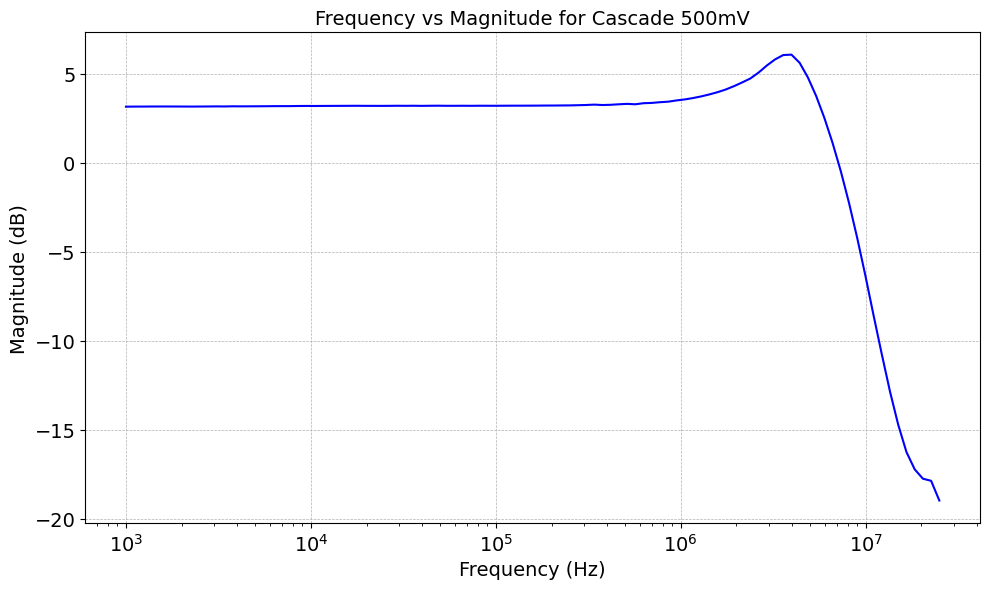

In [105]:
# Group the data by 'source_file'
grouped = combined_df.groupby('source_file')

# Iterate through each group and create a plot
for file_name, group in grouped:
    plt.figure(figsize=(10, 6))
    plt.plot(
        group['Frequency(Hz)'], 
        group['Magnitude(dB)'], 
        label=f"{file_name.replace('_', ' ')}", 
        color='blue', 
        linewidth=1.5
    )
    plt.title(f"Frequency vs Magnitude for {file_name.replace('_', ' ')}", fontsize=14)
    plt.xlabel("Frequency (Hz)", fontsize=14)
    plt.ylabel("Magnitude (dB)", fontsize=14)
    plt.xscale('log')  # Logarithmic scale for frequency
    plt.grid(True, which='major', linestyle='--', linewidth=0.5)
    plt.tick_params(axis='both', which='both', labelsize=14)
    # Uncomment the legend line to include it, if required
    # plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()

File: AD797_100mV, 3dB Frequency: 4.69e+06 Hz, Magnitude: 20.95 dB


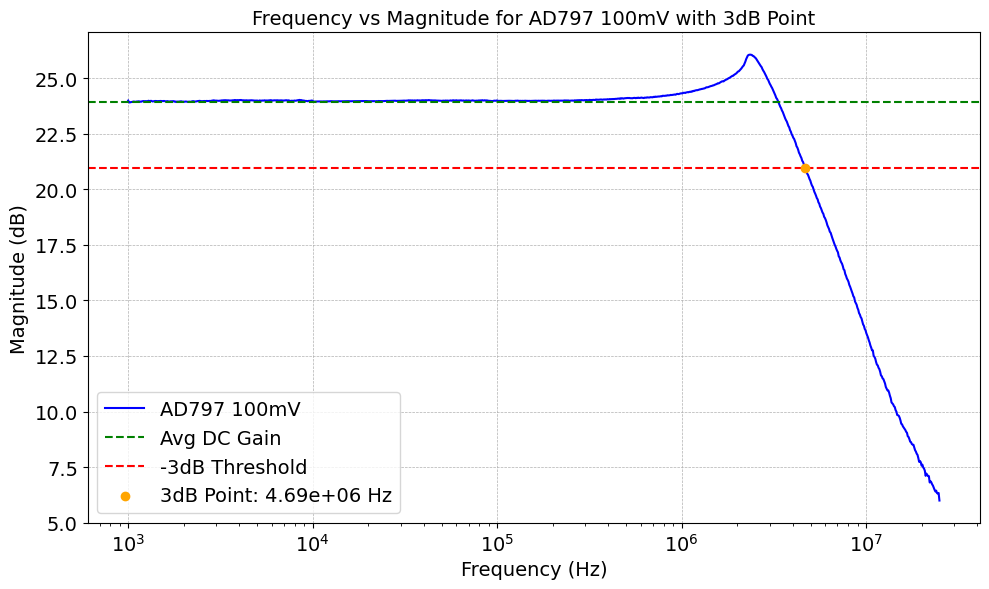

File: AD797_50mV, 3dB Frequency: 6.69e+06 Hz, Magnitude: 20.93 dB


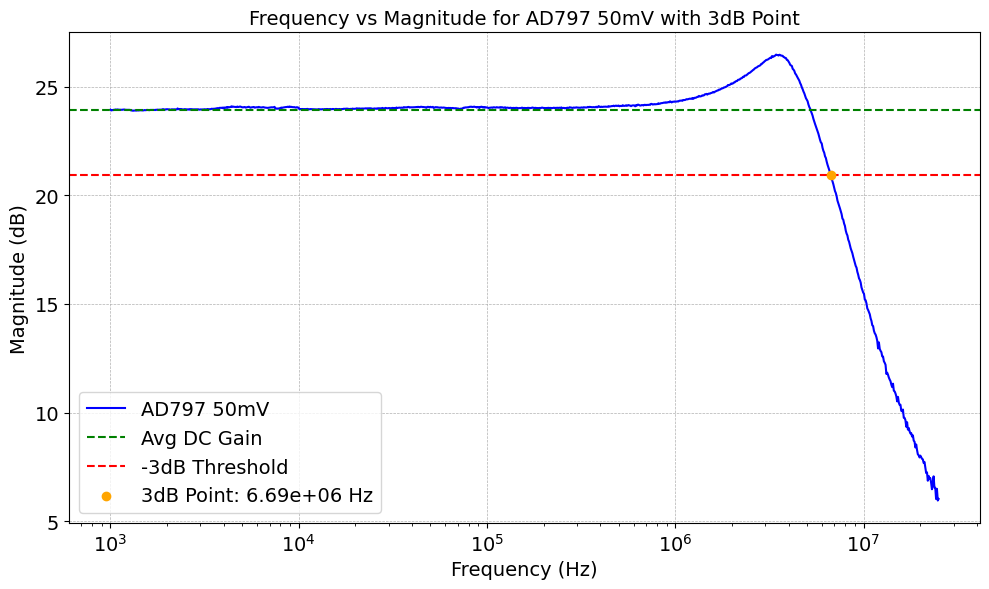

File: ADA4898-1_100mV, 3dB Frequency: 1.07e+07 Hz, Magnitude: 16.37 dB


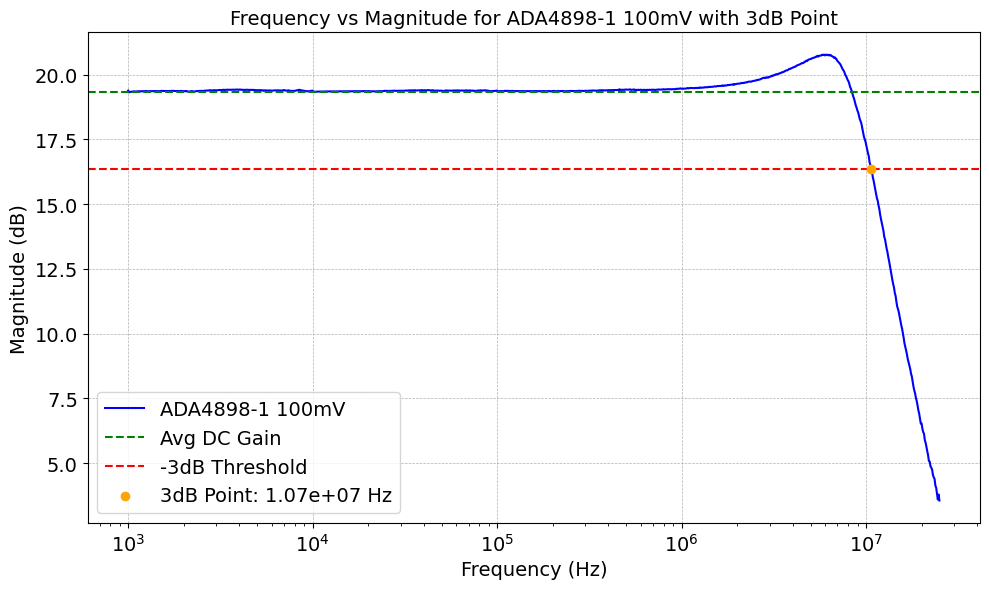

File: ADA4898-1_50mV, 3dB Frequency: 1.10e+07 Hz, Magnitude: 16.36 dB


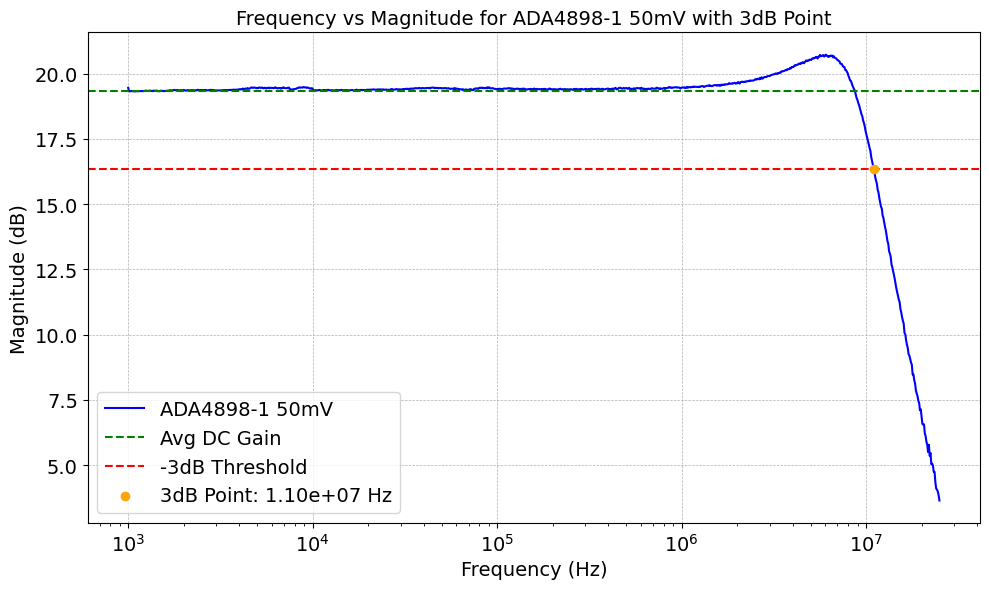

Skipping file: Attenuator_1100th_2V
Skipping file: Attenuator_120th_500mV
File: Cascade_1V, 3dB Frequency: 4.87e+06 Hz, Magnitude: 0.37 dB


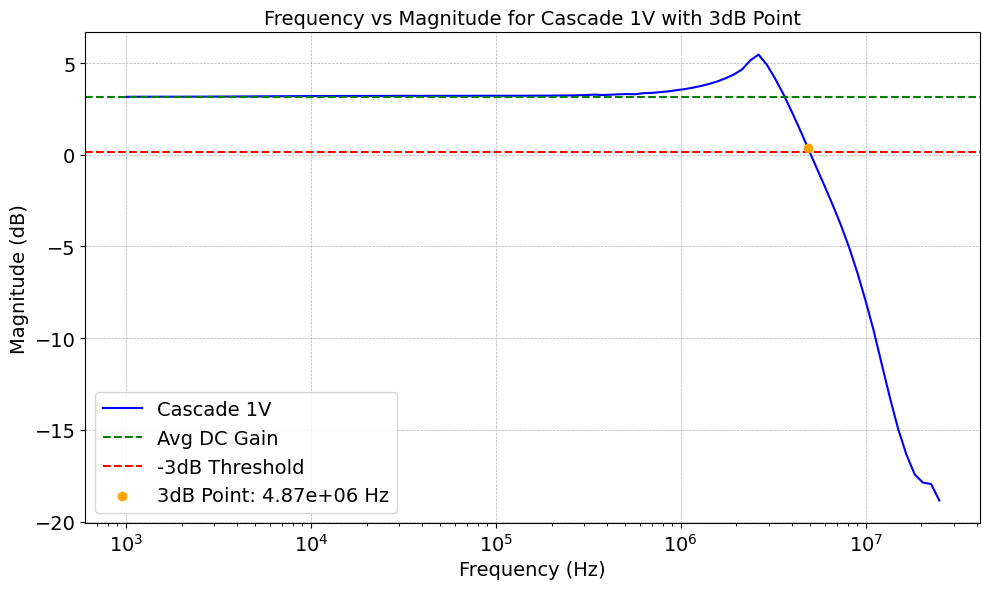

File: Cascade_200mV, 3dB Frequency: 7.33e+06 Hz, Magnitude: 0.84 dB


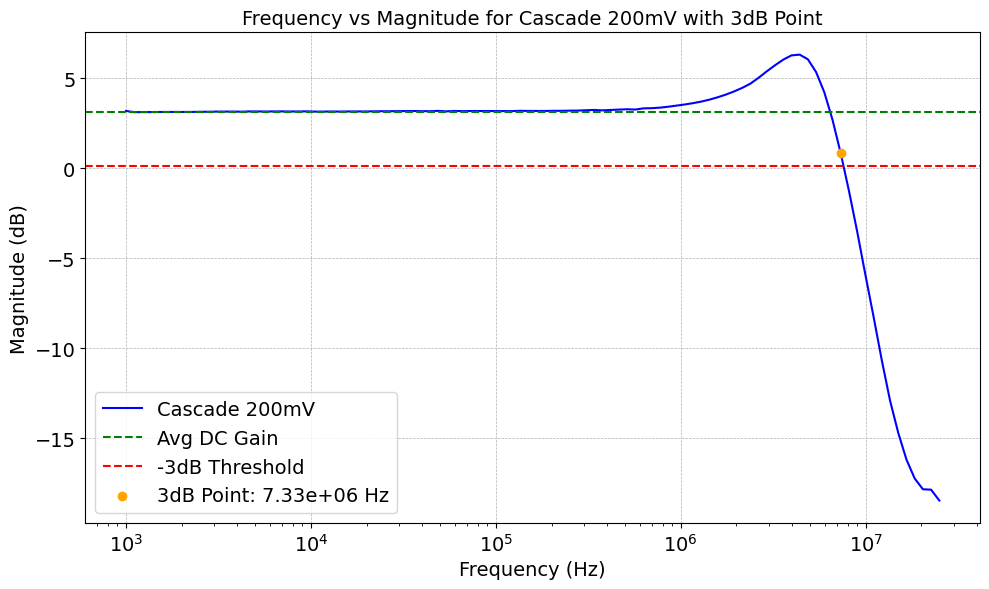

File: Cascade_2V, 3dB Frequency: 2.92e+06 Hz, Magnitude: 0.05 dB


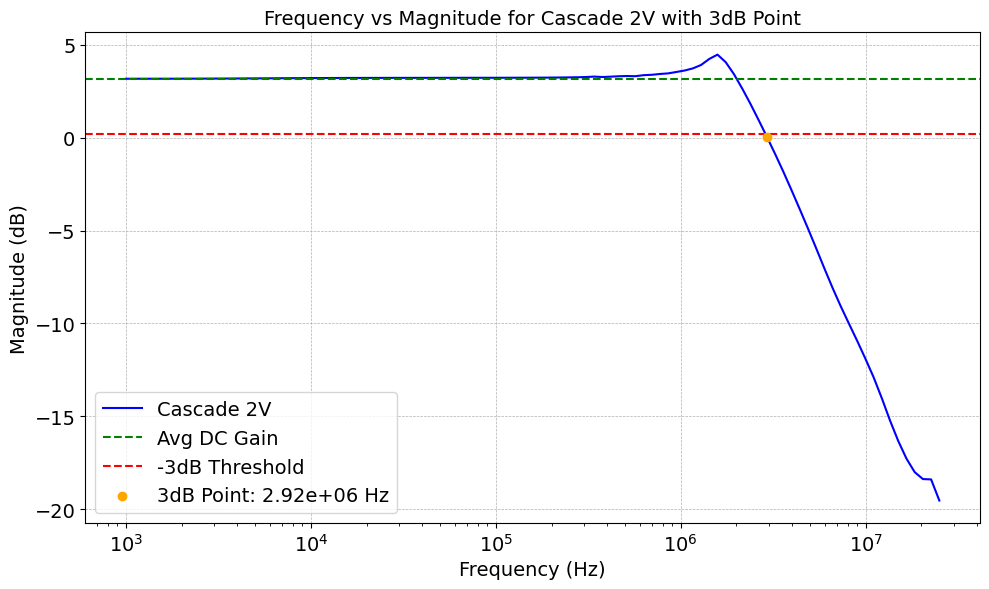

File: Cascade_500mV, 3dB Frequency: 7.33e+06 Hz, Magnitude: -0.45 dB


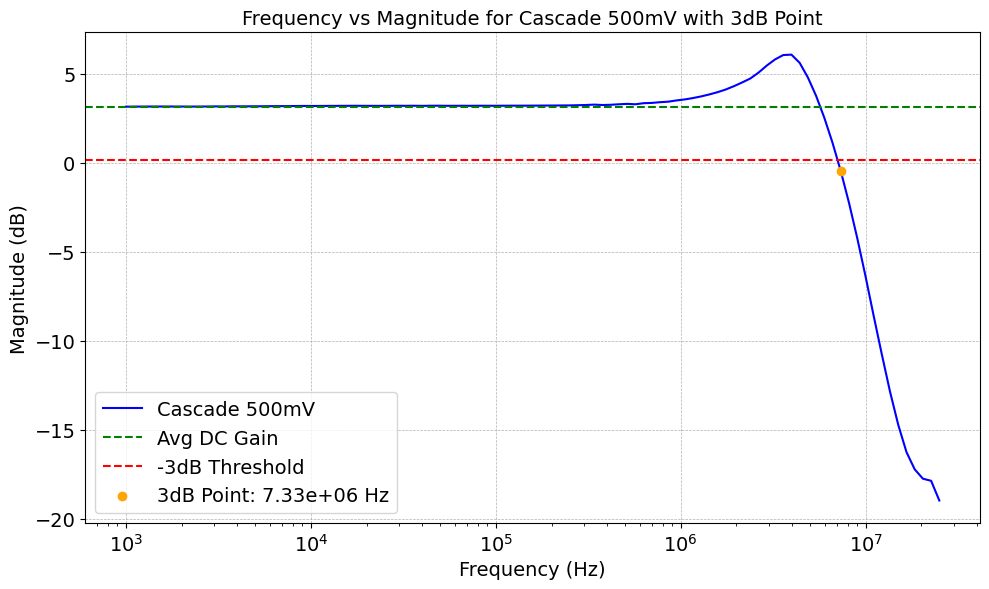

In [106]:
# Function for finding -3dB
def find_cutoff(df, samples_to_average):
    avg_dc_gain = np.mean(df['Magnitude(dB)'][:samples_to_average])
    minus_three_dB_point = avg_dc_gain - 3.0

    min_distance_from_three_db = sys.float_info.max
    min_idx = samples_to_average
    for i in range(samples_to_average, len(df) - 1):
        magnitude = df['Magnitude(dB)'].iloc[i]
        distance_from_three_db = abs(magnitude - minus_three_dB_point)
        
        if distance_from_three_db < min_distance_from_three_db:
            min_distance_from_three_db = distance_from_three_db
            min_idx = i

    frequency = df['Frequency(Hz)'].iloc[min_idx]
    magnitude = df['Magnitude(dB)'].iloc[min_idx]
    return avg_dc_gain, frequency, magnitude

# Group the data by 'source_file'
grouped = combined_df.groupby('source_file')

for file_name, group in grouped:
    # Skip files with "Run4_Atten" at the beginning of their name
    if file_name.startswith("Atten"):
        print(f"Skipping file: {file_name}")
        continue

    # Find the 3dB point
    samples_to_average = 10  # Adjust based on the number of DC samples
    avg_dc_gain, cutoff_frequency, cutoff_magnitude = find_cutoff(group, samples_to_average)

    # Print the 3dB frequency
    print(f"File: {file_name}, 3dB Frequency: {cutoff_frequency:.2e} Hz, Magnitude: {cutoff_magnitude:.2f} dB")

    # Plot the data with the 3dB point highlighted
    plt.figure(figsize=(10, 6))
    plt.plot(
        group['Frequency(Hz)'], 
        group['Magnitude(dB)'], 
        label=f"{file_name.replace('_', ' ')}", 
        color='blue', 
        linewidth=1.5
    )
    plt.axhline(avg_dc_gain, color='green', linestyle='--', label='Avg DC Gain', linewidth=1.5)
    plt.axhline(avg_dc_gain - 3.0, color='red', linestyle='--', label='-3dB Threshold', linewidth=1.5)
    plt.scatter(
        cutoff_frequency, 
        cutoff_magnitude, 
        color='orange', 
        label=f'3dB Point: {cutoff_frequency:.2e} Hz', 
        zorder=5
    )
    plt.title(f"Frequency vs Magnitude for {file_name.replace('_', ' ')} with 3dB Point", fontsize=14)
    plt.xlabel("Frequency (Hz)", fontsize=14)
    plt.ylabel("Magnitude (dB)", fontsize=14)
    plt.xscale('log')  # Logarithmic scale for frequency
    plt.grid(True, which='major', linestyle='--', linewidth=0.5)
    plt.tick_params(axis='both', which='both', labelsize=14)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()

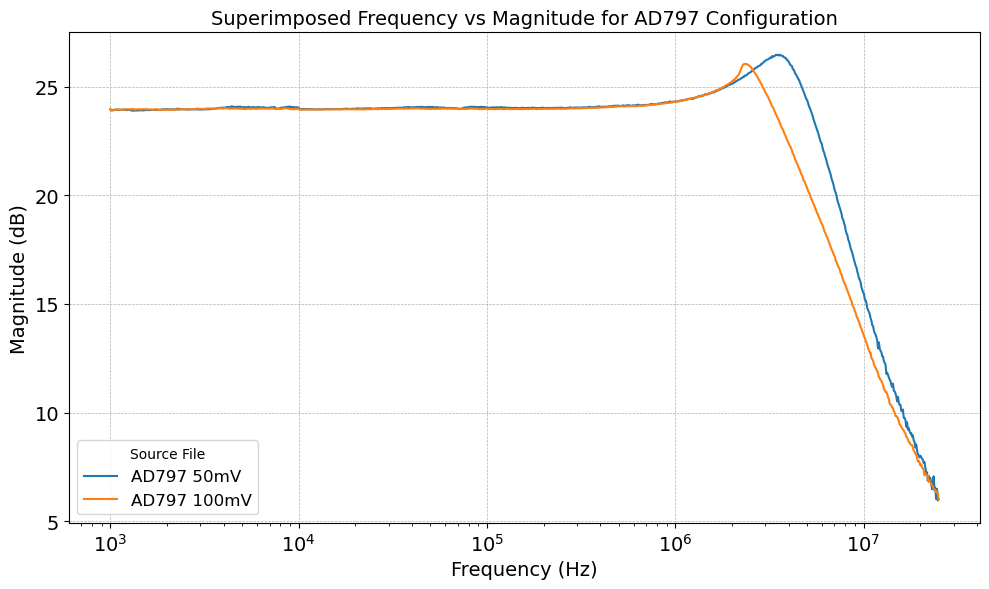

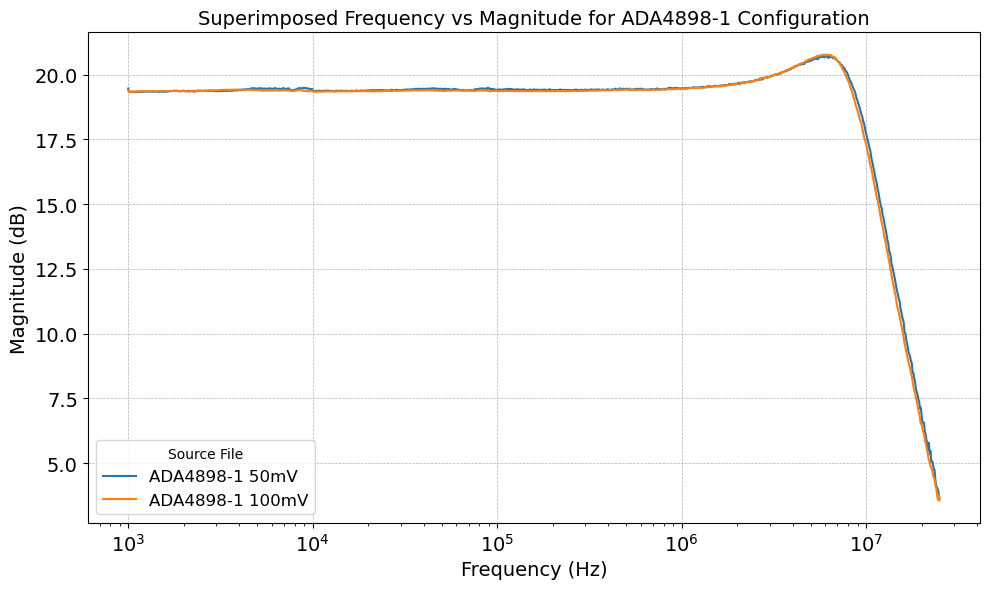

Skipping group: Attenuator


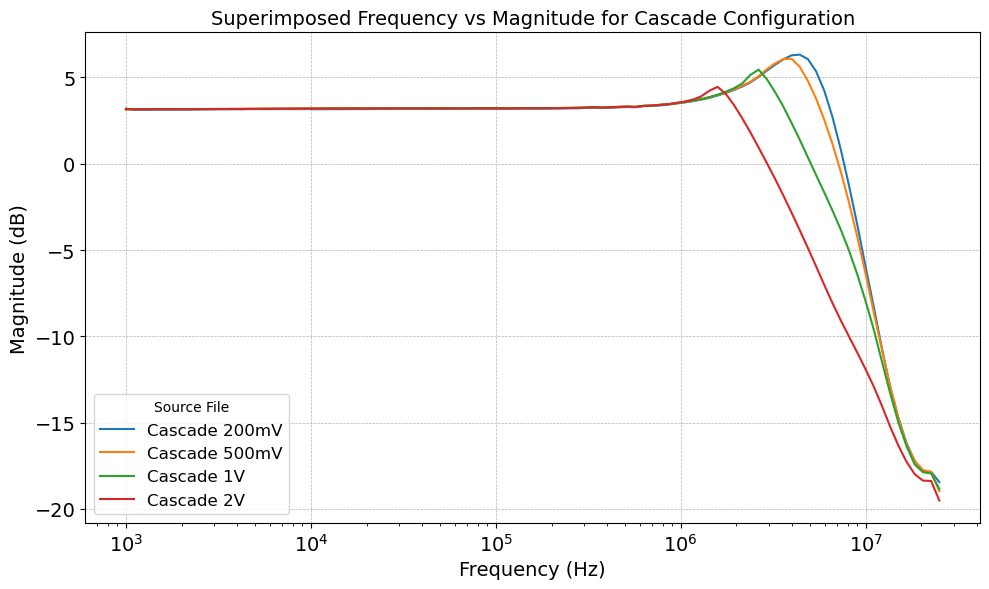

In [107]:
# Extract the prefix from the 'source_file' column
combined_df['file_prefix'] = combined_df['source_file'].str.extract(r'^([^_]+)')

# Group by the extracted prefix
prefix_grouped = combined_df.groupby('file_prefix')

# Loop through each prefix group
for prefix, group in prefix_grouped:
    # Skip groups starting with "Atten"
    if prefix.startswith("Atten"):
        print(f"Skipping group: {prefix}")
        continue

    # Further group by the full source file name within each prefix
    file_groups = group.groupby('source_file')

    # Create a list to store (magnitude, file_name, file_group)
    file_data = []

    for file_name, file_group in file_groups:
        # Extract numeric magnitude from the file name using regex
        match = re.search(r"(\d+\.?\d*)([mM]?[vV])", file_name)
        if match:
            value = float(match.group(1))
            unit = match.group(2).lower()
            if unit == "mv":
                value /= 1000  # Convert mV to V
            file_data.append((value, file_name, file_group))

    # Sort files by extracted magnitude
    file_data.sort(key=lambda x: x[0])  # Sort by the numeric value (converted to V)

    # Plot files in the sorted order
    plt.figure(figsize=(10, 6))
    for _, file_name, file_group in file_data:
        plt.plot(
            file_group['Frequency(Hz)'], 
            file_group['Magnitude(dB)'], 
            label=file_name.replace('_', ' '), 
            linewidth=1.5
        )

    # Add labels and legend
    plt.title(f"Superimposed Frequency vs Magnitude for {prefix.replace('_', ' ')} Configuration", fontsize=14)
    plt.xlabel("Frequency (Hz)", fontsize=14)
    plt.ylabel("Magnitude (dB)", fontsize=14)
    plt.xscale('log')  # Logarithmic scale for frequency
    plt.grid(True, which='major', linestyle='--', linewidth=0.5)
    plt.tick_params(axis='both', which='both', labelsize=14)
    plt.legend(title="Source File", fontsize=12)
    plt.tight_layout()
    plt.show()

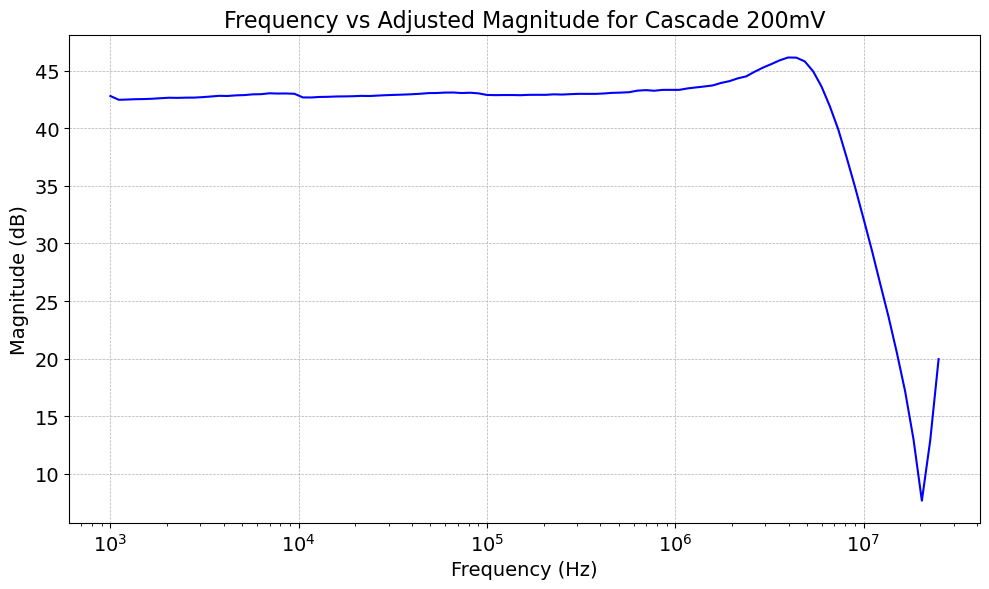

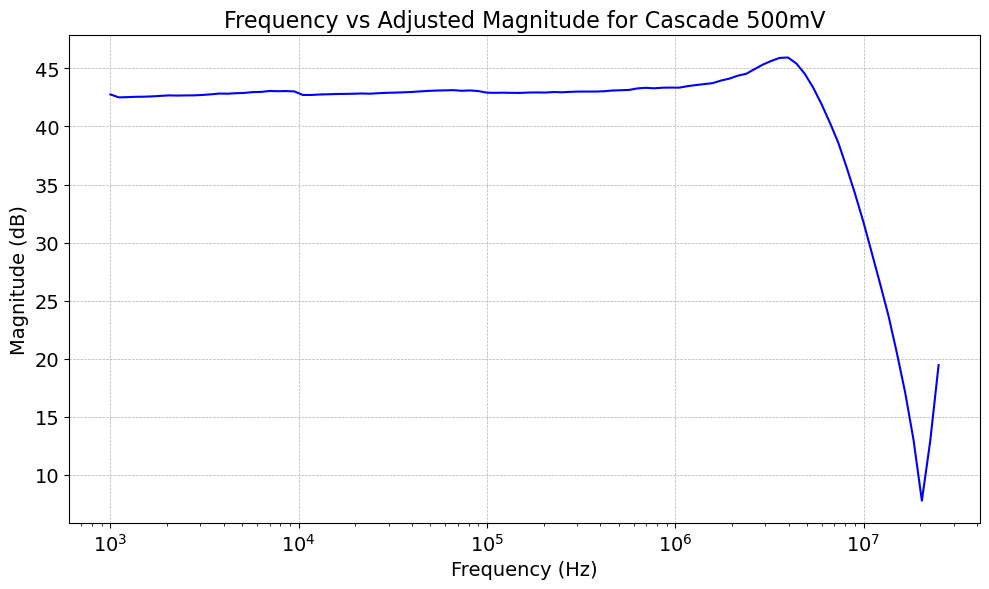

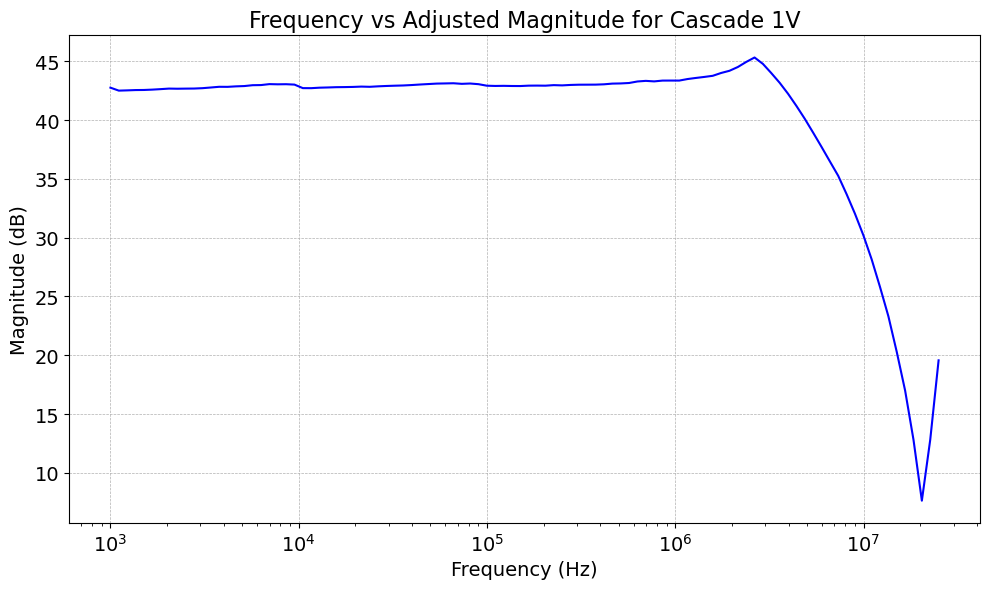

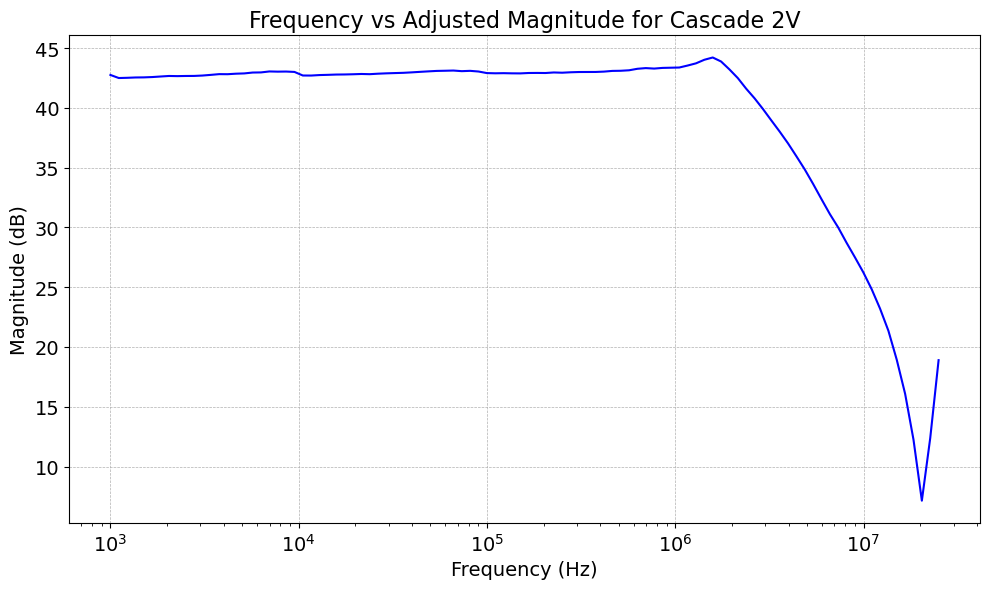

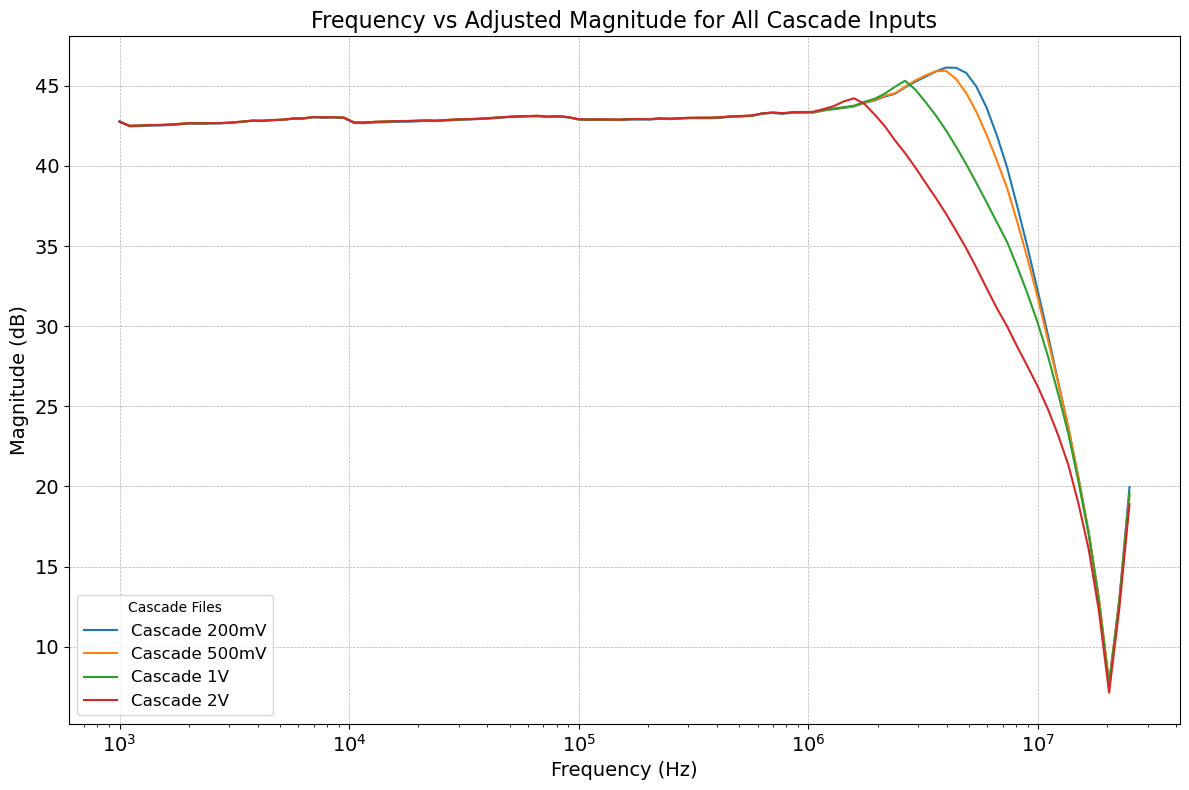

In [110]:
# Extract the Attenuator_1100th file data
attenuator_data = combined_df[combined_df['source_file'] == 'Attenuator_1100th_2V']

# Sort by frequency to ensure proper alignment
attenuator_data = attenuator_data.sort_values('Frequency(Hz)').reset_index(drop=True)

# Extract Cascade files by filtering source_file
cascade_files = combined_df[combined_df['source_file'].str.startswith('Cascade', na=False)]['source_file'].unique()

# Extract numeric magnitudes from file names and sort files
file_data = []
for cascade_file in cascade_files:
    # Extract numeric magnitude from the file name
    match = re.search(r"(\d+\.?\d*)([mM]?[vV])", cascade_file)
    if match:
        value = float(match.group(1))
        unit = match.group(2).lower()
        if unit == "mv":
            value /= 1000  # Convert mV to V
        file_data.append((value, cascade_file))

# Sort files by extracted magnitude
file_data.sort(key=lambda x: x[0])  # Sort by the numeric value (converted to V)

# Plot each Cascade file individually
for _, cascade_file in file_data:
    # Extract Cascade file data
    cascade_data = combined_df[combined_df['source_file'] == cascade_file].sort_values('Frequency(Hz)')
    if cascade_data.empty:
        continue

    # Align frequencies using merge_asof
    aligned_data = pd.merge_asof(
        cascade_data[['Frequency(Hz)', 'Magnitude(dB)']],
        attenuator_data[['Frequency(Hz)', 'Magnitude(dB)']],
        on='Frequency(Hz)',
        direction='nearest',
        suffixes=('', '_attenuator')
    )
    
    # Calculate the amplitude difference
    amplitude_difference = aligned_data['Magnitude(dB)'] - aligned_data['Magnitude(dB)_attenuator']
    
    # Plot the amplitude difference for this Cascade file
    plt.figure(figsize=(10, 6))
    plt.plot(
        aligned_data['Frequency(Hz)'], 
        amplitude_difference, 
        label=cascade_file.replace('_', ' '), 
        linewidth=1.5,
        color = 'blue'
    )
    plt.title(f"Frequency vs Adjusted Magnitude for {cascade_file.replace('_', ' ')}", fontsize=16)
    plt.xlabel("Frequency (Hz)", fontsize=14)
    plt.ylabel("Magnitude (dB)", fontsize=14)
    plt.xscale('log')  # Logarithmic scale for frequency
    plt.tick_params(axis='both', which='both', labelsize=14)
    plt.grid(True, which='major', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Combine all Cascade files in a single plot
plt.figure(figsize=(12, 8))
for _, cascade_file in file_data:
    cascade_data = combined_df[combined_df['source_file'] == cascade_file].sort_values('Frequency(Hz)')
    if cascade_data.empty:
        continue

    # Align frequencies using merge_asof
    aligned_data = pd.merge_asof(
        cascade_data[['Frequency(Hz)', 'Magnitude(dB)']],
        attenuator_data[['Frequency(Hz)', 'Magnitude(dB)']],
        on='Frequency(Hz)',
        direction='nearest',
        suffixes=('', '_attenuator')
    )
    
    # Calculate the amplitude difference
    amplitude_difference = aligned_data['Magnitude(dB)'] - aligned_data['Magnitude(dB)_attenuator']
    
    # Plot the amplitude difference for this Cascade file
    plt.plot(
        aligned_data['Frequency(Hz)'], 
        amplitude_difference, 
        label=cascade_file.replace('_', ' '), 
        linewidth=1.5
    )

# Add labels, title, and legend for the combined plot
plt.title("Frequency vs Adjusted Magnitude for All Cascade Inputs", fontsize=16)
plt.xlabel("Frequency (Hz)", fontsize=14)
plt.ylabel("Magnitude (dB)", fontsize=14)
plt.xscale('log')  # Logarithmic scale for frequency
plt.tick_params(axis='both', which='both', labelsize=14)
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.legend(title="Cascade Files", fontsize=12)
plt.tight_layout()
plt.show()

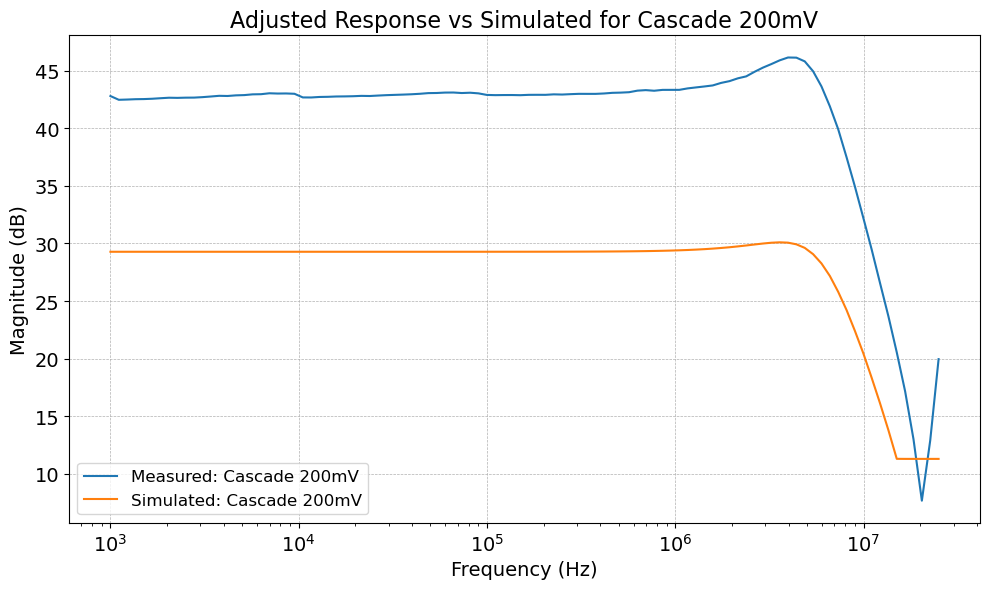

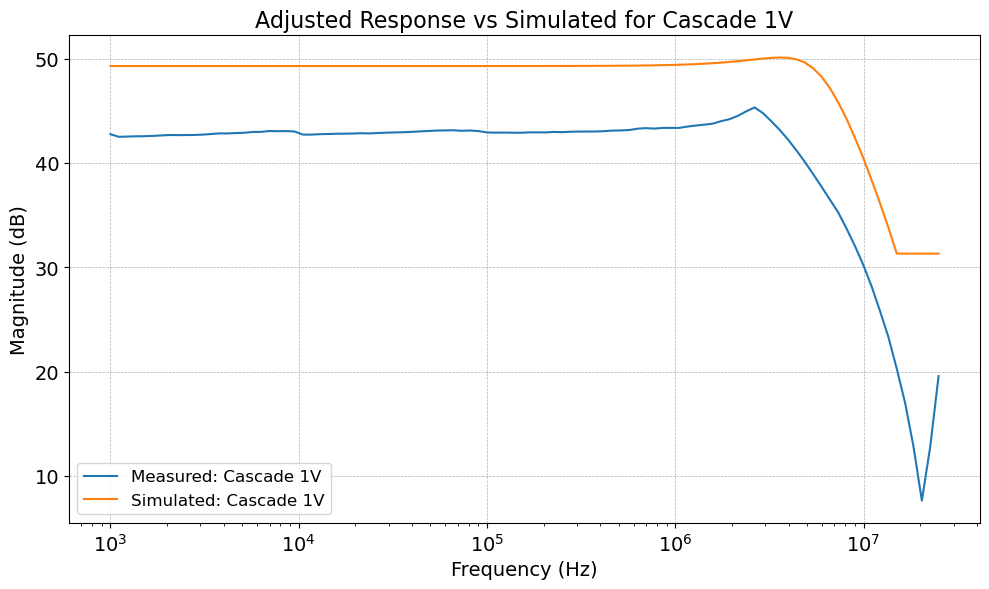

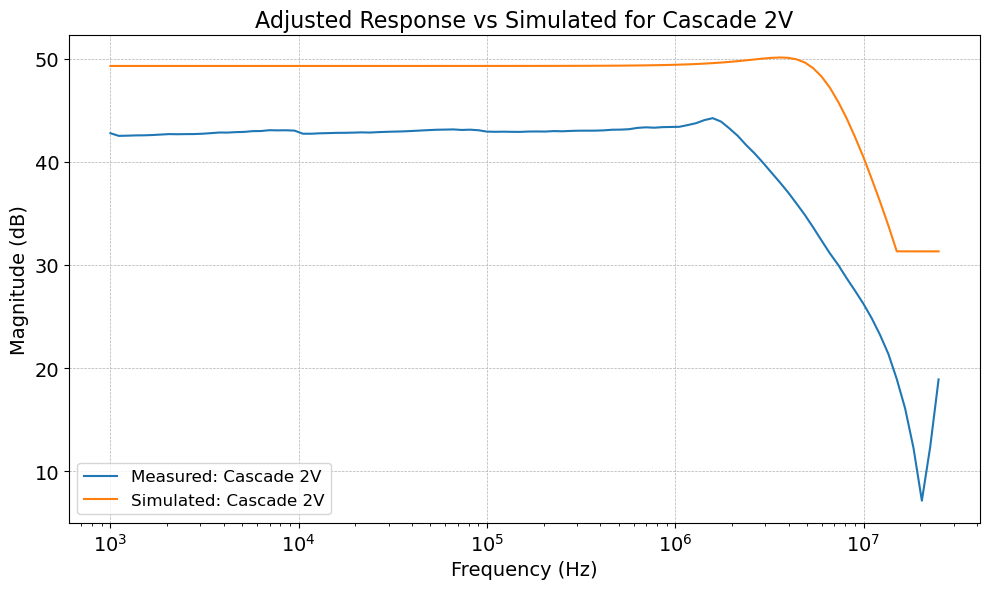

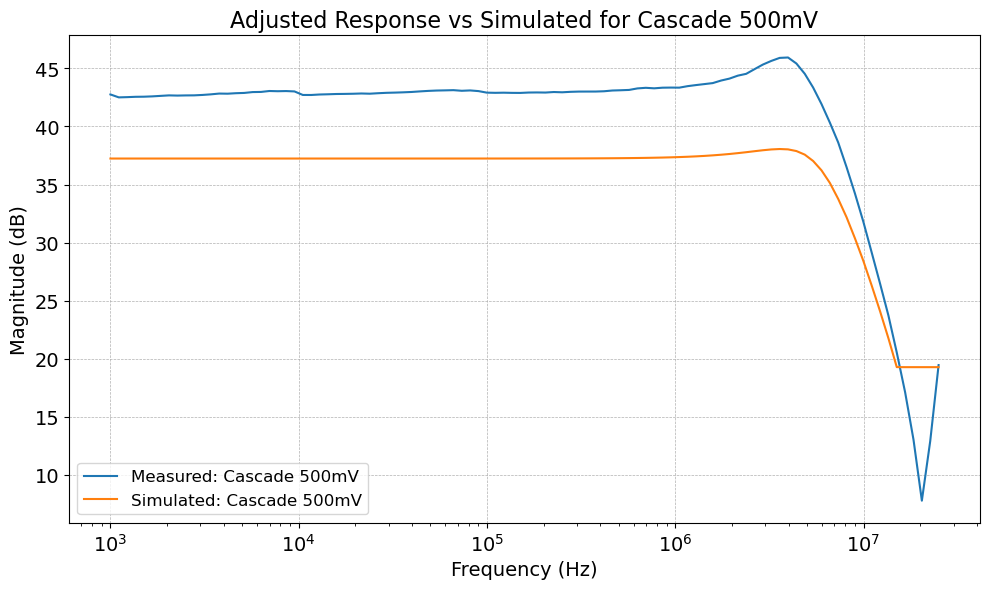

In [109]:
# Extract the Attenuator_1100th file data
attenuator_data = combined_df[combined_df['source_file'] == 'Attenuator_1100th_2V']

# Sort by frequency to ensure proper alignment
attenuator_data = attenuator_data.sort_values('Frequency(Hz)').reset_index(drop=True)

# Extract Cascade files by filtering source_file
cascade_files = combined_df[combined_df['source_file'].str.startswith('Cascade', na=False)]['source_file'].unique()

# Combine measured amplitude differences with simulated data
for cascade_file in cascade_files:
    # Extract Cascade file data
    cascade_data = combined_df[combined_df['source_file'] == cascade_file].sort_values('Frequency(Hz)')
    if cascade_data.empty:
        continue

    # Align frequencies using merge_asof
    aligned_measured = pd.merge_asof(
        cascade_data[['Frequency(Hz)', 'Magnitude(dB)']],
        attenuator_data[['Frequency(Hz)', 'Magnitude(dB)']],
        on='Frequency(Hz)',
        direction='nearest',
        suffixes=('', '_attenuator')
    )

    # Calculate the amplitude difference
    amplitude_difference = aligned_measured['Magnitude(dB)'] - aligned_measured['Magnitude(dB)_attenuator']

    # Find corresponding simulated data
    root = cascade_file
    if root not in simulated_data:
        print(f"No simulated data found for {cascade_file}. Skipping.")
        continue
    sim_data = simulated_data[root].sort_values('Frequency(Hz)')

    # Align frequencies between amplitude difference and simulated data
    aligned_data = pd.merge_asof(
        pd.DataFrame({'Frequency(Hz)': aligned_measured['Frequency(Hz)'], 'Amplitude Difference (dB)': amplitude_difference}),
        sim_data,
        on='Frequency(Hz)',
        direction='nearest',
        suffixes=('_measured', '_simulated')
    )

    # Plot measured amplitude difference vs simulated data
    plt.figure(figsize=(10, 6))
    plt.plot(
        aligned_data['Frequency(Hz)'], aligned_data['Amplitude Difference (dB)'],
        label=f"Measured: {cascade_file.replace('_', ' ')}", linewidth=1.5
    )
    plt.plot(
        aligned_data['Frequency(Hz)'], aligned_data['Simulated Magnitude(dB)'],
        label=f"Simulated: {cascade_file.replace('_', ' ')}", linewidth=1.5
    )
    plt.title(f"Adjusted Response vs Simulated for {cascade_file.replace('_', ' ')}", fontsize=16)
    plt.xlabel("Frequency (Hz)", fontsize=14)
    plt.ylabel("Magnitude (dB)", fontsize=14)
    plt.xscale('log')  # Logarithmic scale for frequency
    plt.tick_params(axis='both', which='both', labelsize=14)
    plt.grid(True, which='major', linestyle='--', linewidth=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()